In [29]:
import glob, os
import fnmatch
import sys
import astropy
import json
import parsnip
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
#read from .json file

for file in os.listdir("T202103221404394p014626/"):
    if file.endswith(".json"):
        f = open('T202103221404394p014626/'+file)
        data = json.load(f)
        id = data["ObjectID"]
        ra = data['RA-OBJECT']
        dec = data['DEC-OBJECT']
        print (id, ra, dec)

T202103221404394p014626 211.16428283 1.77410113


In [3]:
#read from pdf file

from tika import parser
for file in os.listdir("T202103221404394p014626/"):
    if file.endswith(".pdf"):
        pdf = parser.from_file('T202103221404394p014626/'+file)
        text = pdf['content']

In [4]:
rs = ""
for i in range(len(text)):
    if text[i].startswith("T"):
        for j in range(i+36, i+43):
            rs += text[j]
        break
rs = float(rs)
print (rs)

0.22975


In [5]:
#construct a metadata table

from astropy.table import QTable, Table, Column
import numpy as np
metaTable = Table(names=('object_id', 'ra', 'dec', 'type', 'redshift'), dtype=('S2', 'i', 'i', 'S', 'f'))
metaTable.add_row((id, ra, dec, 'Unknown', rs))
print (metaTable)

       object_id         ra dec   type  redshift
----------------------- --- --- ------- --------
T202103221404394p014626 211   1 Unknown  0.22975


In [18]:
#read from .csv file

import csv
import lcdata

lightcurveTable = Table(names=('time(mjd)', 'flux', 'fluxerr', 'band'), dtype=('f', 'f', 'f', 'S'))

for file in os.listdir("T202103221404394p014626/"):
    if file.endswith(".csv"):
        csvFile = open('T202103221404394p014626/'+file)
        reader = csv.DictReader(csvFile)
        for row in reader:
            if row['alert'] == 'True':
                time = row['mjd']
                mag = float(row['mag'])
                magerr = float(row['magerr'])
                flux = 10**((22.5-mag)/2.5)
                fluxerr = fluxerr = flux * np.log(10) / 2.5 * magerr
                band = 'ps1::' + row['filter']
                lightcurveTable.add_row((time, flux, fluxerr, band))
print (lightcurveTable)

time(mjd)    flux      fluxerr    band 
--------- ---------- ----------- ------
 59295.27  2.8618915 0.090408474 ps1::g
59295.273   2.875543  0.07861171 ps1::r
59295.273  1.9632537  0.16095826 ps1::z
59297.227  2.6797485 0.115832634 ps1::g
59297.227  2.3984513  0.08548449 ps1::r
 59297.23  1.6680049  0.17767365 ps1::z
59301.188  3.3626912  0.31039804 ps1::r
59301.188  2.3671358   0.2699927 ps1::z
59307.336  3.0541835  0.27327675 ps1::g
 59310.19   2.031543  0.09946068 ps1::g
      ...        ...         ...    ...
 59319.17  1.3874642 0.070573896 ps1::g
59319.176  1.9609144  0.07359017 ps1::r
59319.176  1.4081056  0.16771111 ps1::z
59319.305  1.3832716   0.0759118 ps1::g
59322.176  1.5523274  0.07836565 ps1::r
59322.176  1.3023627  0.16841514 ps1::z
  59322.3  1.1492501  0.09278198 ps1::g
 59340.15  1.1042311 0.094568364 ps1::r
59343.152 0.98615205   0.1357914 ps1::r
59346.156  1.1942683  0.11313347 ps1::r
59352.082 0.78507364 0.084839925 ps1::r
Length = 30 rows


In [19]:
#combine the two tables into lcdata

light_curve = Table({
     'time': list(lightcurveTable['time(mjd)']),
     'flux': list(lightcurveTable['flux']),
     'fluxerr': list(lightcurveTable['fluxerr']),
     'band': list(lightcurveTable['band']),})

print(light_curve, '\n')

light_curve.meta = {
    'object_id': id,
    'ra': ra,
    'dec': dec,
    'type': "Unknown",
    'redshift': rs}

print(light_curve.meta)

   time      flux      fluxerr    band 
--------- ---------- ----------- ------
 59295.27  2.8618915 0.090408474 ps1::g
59295.273   2.875543  0.07861171 ps1::r
59295.273  1.9632537  0.16095826 ps1::z
59297.227  2.6797485 0.115832634 ps1::g
59297.227  2.3984513  0.08548449 ps1::r
 59297.23  1.6680049  0.17767365 ps1::z
59301.188  3.3626912  0.31039804 ps1::r
59301.188  2.3671358   0.2699927 ps1::z
59307.336  3.0541835  0.27327675 ps1::g
 59310.19   2.031543  0.09946068 ps1::g
      ...        ...         ...    ...
 59319.17  1.3874642 0.070573896 ps1::g
59319.176  1.9609144  0.07359017 ps1::r
59319.176  1.4081056  0.16771111 ps1::z
59319.305  1.3832716   0.0759118 ps1::g
59322.176  1.5523274  0.07836565 ps1::r
59322.176  1.3023627  0.16841514 ps1::z
  59322.3  1.1492501  0.09278198 ps1::g
 59340.15  1.1042311 0.094568364 ps1::r
59343.152 0.98615205   0.1357914 ps1::r
59346.156  1.1942683  0.11313347 ps1::r
59352.082 0.78507364 0.084839925 ps1::r
Length = 30 rows 

{'object_id': 'T20210

In [20]:
#create a dataset with the light curve(s)

dataset = lcdata.from_light_curves([light_curve])
print(dataset.meta)

       object_id             ra         dec       type  redshift
----------------------- ------------ ---------- ------- --------
T202103221404394p014626 211.16428283 1.77410113 Unknown  0.22975


In [21]:
print (dataset.light_curves)

[<Table length=30>
      time         flux      fluxerr    band
    float64      float32     float32   bytes6
 -------------- ---------- ----------- ------
 59295.26953125  2.8618915 0.090408474 ps1::g
  59295.2734375   2.875543  0.07861171 ps1::r
  59295.2734375  1.9632537  0.16095826 ps1::z
  59297.2265625  2.6797485 0.115832634 ps1::g
  59297.2265625  2.3984513  0.08548449 ps1::r
 59297.23046875  1.6680049  0.17767365 ps1::z
     59301.1875  3.3626912  0.31039804 ps1::r
     59301.1875  2.3671358   0.2699927 ps1::z
  59307.3359375  3.0541835  0.27327675 ps1::g
 59310.19140625   2.031543  0.09946068 ps1::g
            ...        ...         ...    ...
 59319.17578125  1.9609144  0.07359017 ps1::r
 59319.17578125  1.4081056  0.16771111 ps1::z
  59319.3046875  1.3832716   0.0759118 ps1::g
 59322.17578125  1.5523274  0.07836565 ps1::r
 59322.17578125  1.3023627  0.16841514 ps1::z
 59322.30078125  1.1492501  0.09278198 ps1::g
  59340.1484375  1.1042311 0.094568364 ps1::r
 59343.15234375 

In [22]:
print(dataset.meta)

       object_id             ra         dec       type  redshift
----------------------- ------------ ---------- ------- --------
T202103221404394p014626 211.16428283 1.77410113 Unknown  0.22975


In [23]:
#save the dataset into .h5 file and read from that file (to test if we still get the same error)

#dataset = lcdata.from_light_curves([light_curve])
#dataset.write_hdf5('./dataset.h5')

#dataset = parsnip.load_dataset('./dataset.h5')

In [24]:
#make prediction with the built-in ps1 model
#this cell was run before meeting 7/6, when I changed the band names into "ps1::", so it produced outcomes without error

model = parsnip.load_model('ps1')
model.predict(light_curve)

{'object_id': 'T202103221404394p014626',
 'ra': 211.16428283,
 'dec': 1.77410113,
 'type': 'Unknown',
 'redshift': 0.22975,
 'parsnip_reference_time': 59310.20035515625,
 'parsnip_scale': 3.3626912,
 'reference_time': 59303.248031719515,
 'reference_time_error': 0.44723448,
 'color': -0.14607616,
 'color_error': 0.018412067,
 'amplitude': 0.061245665,
 'amplitude_error': 0.0005945595,
 's1': -1.1694034,
 's1_error': 0.33034235,
 's2': 0.2416011,
 's2_error': 0.7339637,
 's3': 0.3604813,
 's3_error': 0.09951817,
 'total_s2n': 111.19419,
 'count': 30,
 'count_s2n_3': 30,
 'count_s2n_5': 30,
 'count_s2n_3_pre': 0,
 'count_s2n_3_rise': 8,
 'count_s2n_3_fall': 22,
 'count_s2n_3_post': 0,
 'model_chisq': 237.18626,
 'model_dof': 24,
 'luminosity': -12.331816575653455,
 'luminosity_error': 0.01054045}

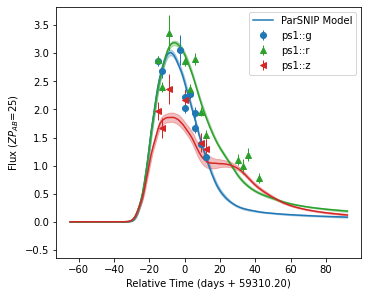

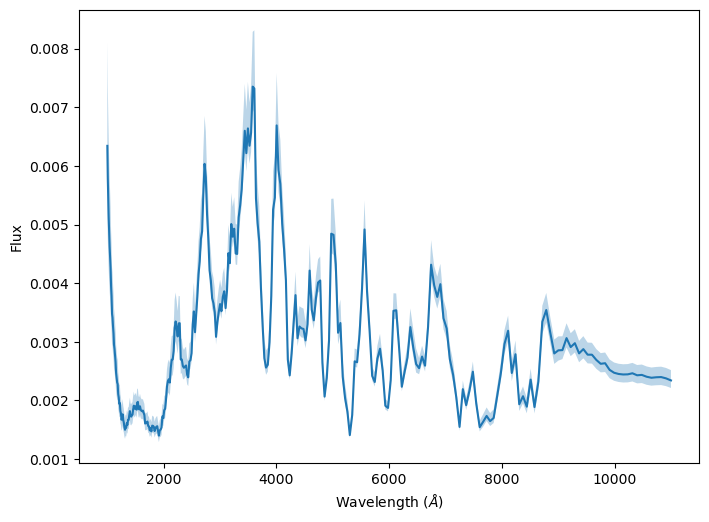

In [25]:
#make plots with the model

parsnip.plot_light_curve(light_curve, model)
parsnip.plot_spectrum(light_curve, model, time=53000.)

In [27]:
raw_predictions = Table.read('parsnip_predictions/parsnip_predictions_ps1_aug_100.h5')

# Only keep predictions for objects in the supervised sample
predictions_ps1 = raw_predictions[raw_predictions['supervised']].copy()

# This is a dataset containing both augmented and original objects.
# Make a mask to pull out the original objects.
original_mask_ps1 = ~predictions_ps1['augmented']

Training classifier with keys:
    color
    color_error
    s1
    s1_error
    s2
    s2_error
    s3
    s3_error
    luminosity
    luminosity_error
    reference_time_error
[100]	valid_0's multi_logloss: 0.300127
[100]	valid_0's multi_logloss: 1.01522
[100]	valid_0's multi_logloss: 0.386745
[100]	valid_0's multi_logloss: 0.849632
[100]	valid_0's multi_logloss: 0.386095
[100]	valid_0's multi_logloss: 0.903243
[100]	valid_0's multi_logloss: 0.474693
[100]	valid_0's multi_logloss: 0.512012
[100]	valid_0's multi_logloss: 0.285442
[100]	valid_0's multi_logloss: 1.40803
Macro averaged completeness (Villar et al. 2020): 0.7888
Fraction correct: 0.8923


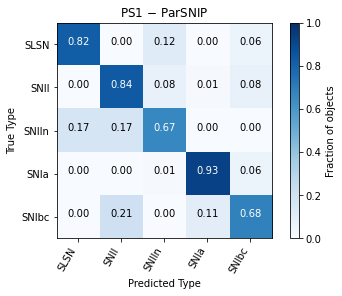

In [30]:
classifier_ps1 = parsnip.Classifier()
classifications_ps1 = classifier_ps1.train(predictions_ps1)
parsnip.plot_confusion_matrix(predictions_ps1[original_mask_ps1], classifications_ps1[original_mask_ps1],
                              title='PS1 $-$ ParSNIP')
plt.savefig('ps1_confusion_matrix.pdf')

In [32]:
classifier_ps1.classify(dataset)

KeyError: 'color'